In [ ]:
# !curl http://files.fast.ai/data/dogscats.zip --output data/dogscats.zip
# !unzip data/dogscats.zip 

In [21]:
# !rm -rf data/dogscats

In [ ]:
# !unzip data/dogscats.zip -d data/loaded/

In [4]:
import fastai

In [5]:
from fastai.imports import *

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = "data/loaded/dogscats/"
sz = 224

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.backends.cudnn.enabled

True

In [9]:
os.listdir(PATH)

['sample', 'train', 'models', 'test1', 'valid']

In [10]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [26]:
files = os.listdir(f'{PATH}valid/cats')[50:55]
files

['cat.6647.jpg',
 'cat.7382.jpg',
 'cat.12106.jpg',
 'cat.8508.jpg',
 'cat.9107.jpg']

In [27]:
sns.set_style('whitegrid')

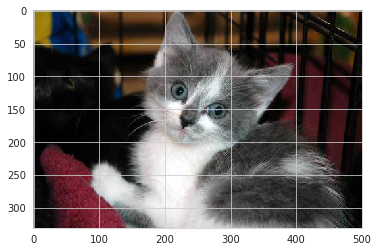

In [28]:
img = plt.imread(f'{PATH}valid/cats/{files[4]}')
plt.imshow(img);

In [29]:
img.shape

(331, 500, 3)

In [30]:
img[:4, :4]

array([[[136, 111,  11],
        [136, 111,  11],
        [137, 112,  11],
        [139, 114,  13]],

       [[136, 111,  11],
        [137, 112,  12],
        [138, 113,  12],
        [139, 114,  13]],

       [[137, 112,  12],
        [138, 113,  12],
        [139, 114,  13],
        [140, 115,  14]],

       [[138, 113,  12],
        [138, 113,  12],
        [139, 114,  13],
        [141, 116,  15]]], dtype=uint8)

In [31]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 32/32 [00:20<00:00,  2.07it/s]



epoch      trn_loss   val_loss   accuracy   
    0      0.05724    0.026411   0.99      
    1      0.035255   0.026433   0.9905    


[array([0.02643]), 0.9905]

In [33]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
data.classes

['cats', 'dogs']

In [35]:
data

In [36]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [37]:
log_preds[:10]

array([[ -0.00108,  -6.82933],
       [ -0.00006,  -9.76796],
       [ -0.00004, -10.16362],
       [ -0.03788,  -3.2922 ],
       [ -0.     , -13.50934],
       [ -0.00011,  -9.14295],
       [ -0.0001 ,  -9.23311],
       [ -0.00006,  -9.65619],
       [ -0.00026,  -8.24409],
       [ -0.     , -12.39208]], dtype=float32)

In [38]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])

In [39]:
def rand_by_mask(mask): 
  return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
  return rand_by_mask((preds == data.val_y) == is_correct)

In [40]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
  f = plt.figure(figsize=figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims) // rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i])

In [41]:
def load_img_id(ds, idx):
  return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
  imgs = [load_img_id(data.val_ds, x) for x in idxs]
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found')

Correctly classified


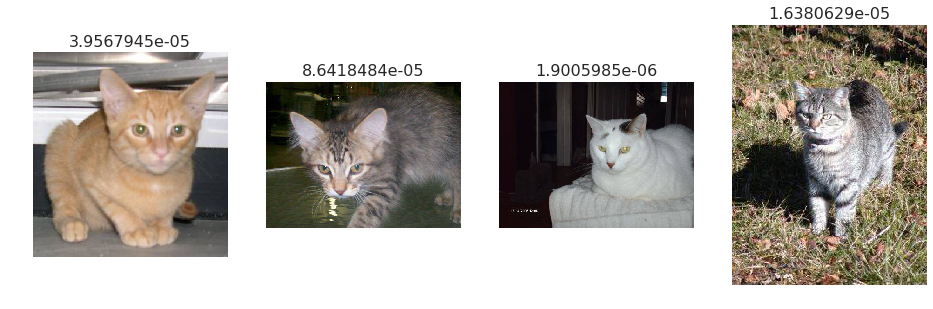

In [42]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


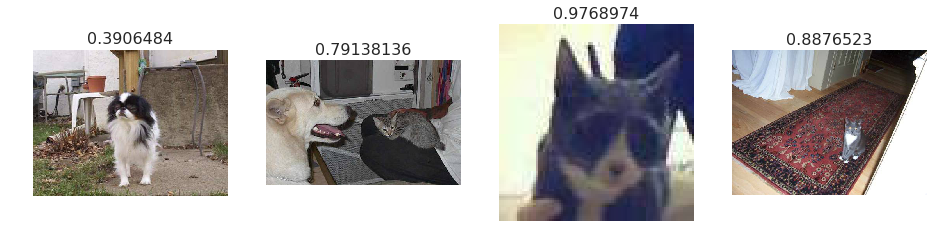

In [43]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [44]:
def most_by_mask(mask, mult):
  idxs = np.where(mask)[0]
  return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
  mult = -1 if(y==1)==is_correct else 1
  return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


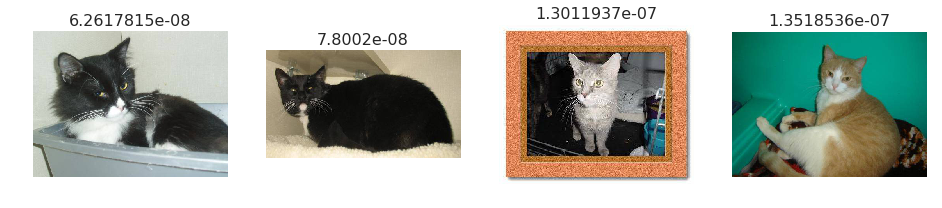

In [45]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


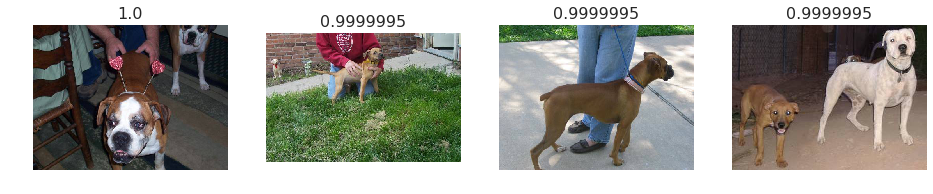

In [46]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


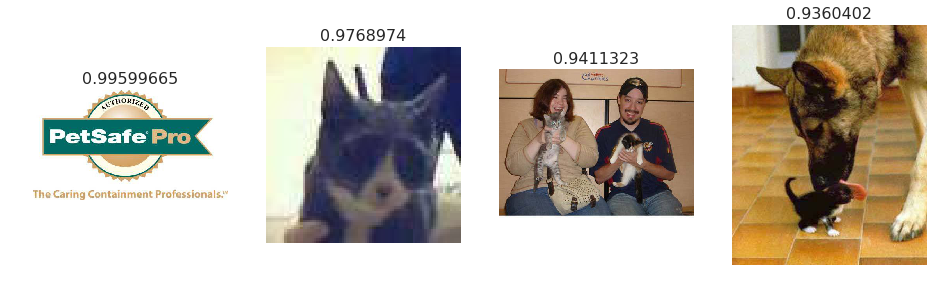

In [47]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


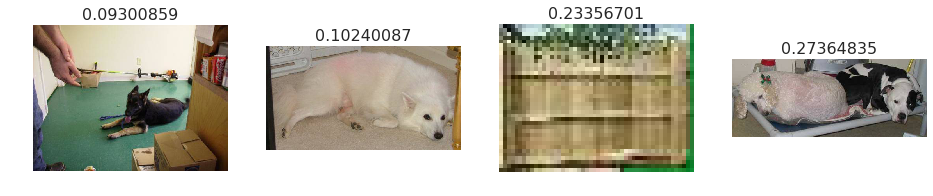

In [48]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


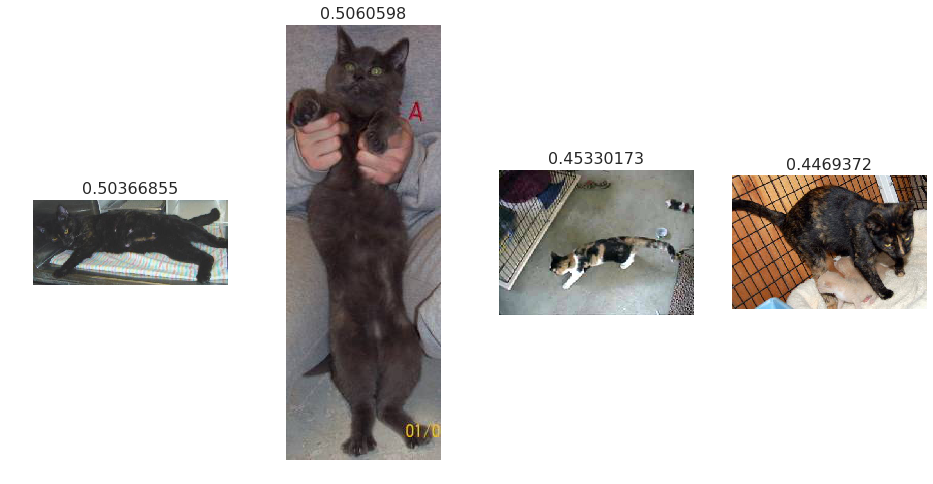

In [49]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [50]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [51]:
lrf=learn.lr_find()

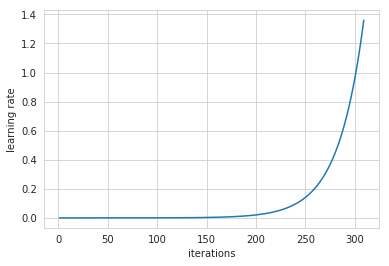

In [52]:
learn.sched.plot_lr()

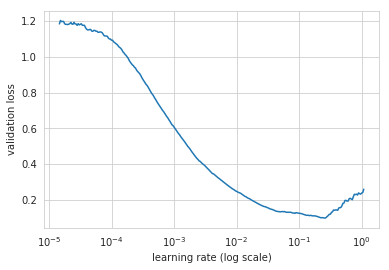

In [53]:
learn.sched.plot()

In [54]:
arch = resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy   
    0      0.055278   0.029605   0.989     


[array([0.02961]), 0.989]

In [55]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [56]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [57]:
ims = np.stack([get_augs() for i in range(6)])

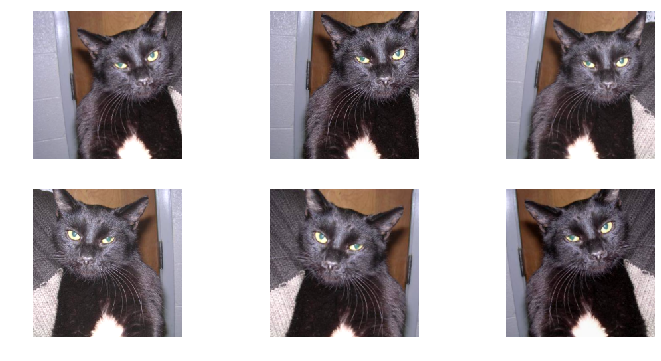

In [58]:
plots(ims, rows=2)

In [59]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [60]:
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy   
    0      0.043448   0.027856   0.9905    


[array([0.02786]), 0.9905]

In [61]:
learn.precompute=False

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.04911    0.025789   0.991     
    1      0.045799   0.02691    0.99      
 25%|██▌       | 90/360 [01:17<04:31,  1.01s/it, loss=0.0457]

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

In [ ]:
learn.unfreeze()

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")